In [ ]:
# !pip install -e git+https://github.com/AndreCNF/shap.git@f0777334bd82a1bacad578eaf1931c3ecbf40ec6#egg=shap
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 564 kB 5.7 MB/s 


In [ ]:
!pip install tensorflow==2.5.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 454.3 MB 17 kB/s 
     |████████████████████████████████| 1.2 MB 39.1 MB/s 
     |████████████████████████████████| 132 kB 48.2 MB/s 
     |████████████████████████████████| 14.8 MB 25.4 MB/s 
     |████████████████████████████████| 462 kB 42.8 MB/s 
     |████████████████████████████████| 4.0 MB 39.3 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68722 sha256=3eb16b52a8d369d9647a1f58fb54eb183e9aa7400f7066cc20eb9c1d4841d990
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.2.0
    Uninstalling typing-extensions-4.2.0:
      Successfully uninstalled typing-extensions-4.2.0
  Attempting uninstall: numpy
    Found existing installation: n

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import shap

from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Reshape
import tensorflow as tf

In [ ]:
tf.__version__

'2.5.0'

In [ ]:
shap.__version__

'0.40.0'

In [ ]:
df = read_csv('data_single_loc.csv')
df

,t2m,d2m,msl,tp,ssrd,Date Time,windspeed_10,windspeed_100
0,262.714033,259.900872,103298.015394,0.000000,0.0,1950-01-01 00:00:00,2.489513,3.817744
1,260.695745,258.184905,103401.866726,0.000000,0.0,1950-01-01 01:00:00,1.837656,3.726080
2,260.195929,257.699157,103434.928307,0.000000,0.0,1950-01-01 02:00:00,2.599009,3.537574
3,259.350219,256.948053,103418.318422,0.000000,0.0,1950-01-01 03:00:00,2.534284,3.147813
4,258.763065,256.665744,103419.030274,0.000000,0.0,1950-01-01 04:00:00,2.623488,3.713367
...,...,...,...,...,...,...,...,...
622387,274.643734,274.172750,100974.912154,0.000006,0.0,2020-12-31 19:00:00,0.809895,1.810642
622388,274.719036,274.144356,100973.148236,0.000005,0.0,2020-12-31 20:00:00,0.868971,1.490224
622389,274.310849,273.971416,100980.668096,0.000003,0.0,2020-12-31 21:00:00,0.774225,1.328229
622390,273.450250,273.092257,100972.962561,0.000002,0.0,2020-12-31 22:00:00,0.649268,0.561700


In [ ]:
train = df[df['Date Time']>='1994-01-01']
train = train[train['Date Time']<'2002-01-01']

test = df[df['Date Time']>='2002-01-01']
test = test[test['Date Time']<'2003-01-01']

In [ ]:
def datetimeToSignal(df):
    date_time = pd.to_datetime(df.pop('Date Time'), infer_datetime_format=True)

    def datetime_to_seconds(dates):
        return (float)((dates - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'))

    timestamp_s = date_time.map(datetime_to_seconds)

    day = 24*60*60
    year = (365.2425)*day

    df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
    df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
    
    return df

Text(0.5, 1.0, 'Time of day signal')

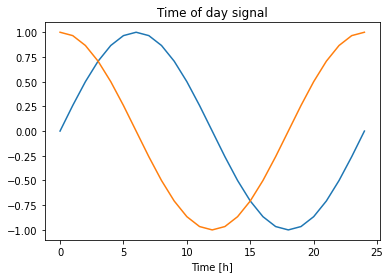

In [ ]:
train = datetimeToSignal(train)
test = datetimeToSignal(test)

plt.plot(np.array(train['Day sin'])[:25])
plt.plot(np.array(train['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [ ]:
values_train = train.values
values_test = test.values

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(values_train)
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaler_y.fit(values_train[:,5].reshape(len(values_train),1))

values_train = scaler.transform(values_train)
values_test = scaler.transform(values_test)

In [ ]:
# One step predicted:
def to_supervised(data, n_input, n_out=1):
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end < len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[out_end-1, 5]) # 5 indicates 'windspeed10' parameter
        # move along one time step
        in_start += 1
    return array(X), array(y).reshape((len(y),1))

X_train, y_train = to_supervised(values_train, n_input=24, n_out=6)
X_test, y_test = to_supervised(values_test, n_input=24, n_out=6)

In [ ]:
def compile_and_fit(model, X_train, y_train):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                   patience=2,
                                                   mode='min')

    model.compile(loss='mean_squared_error',
                  optimizer='adam')

    model.fit(X_train, y_train, epochs=20, batch_size=32, callbacks=[early_stopping])

def evaluate(model, X_test, y_test, display = True):
    # make predictions
    testPredictions = model.predict(X_test)

    # invert scalling
    testPredictions = scaler_y.inverse_transform(testPredictions)
    testYTrue = scaler_y.inverse_transform(y_test)

    # calculate RMSE
    testScore = sqrt(mean_squared_error(testYTrue, testPredictions))
    
    if display:
        print('Test Score: %.4f RMSE' % (testScore))
        length = 168
        start = random.randrange(len(testYTrue)-length)
        end = start+length
        plt.figure(figsize=[10,5])
        plt.xlabel('TimePoint in hours')
        plt.ylabel('$windspeed_{10}[m/s]$')
        plt.grid()
        plt.plot(range(length), testYTrue[start:end],'k.')
        plt.plot(range(length),testPredictions[start:end],'r')
        plt.legend(['Actual','Predicted'])

    return testScore

def cross_corr(model, X_test, y_test):
    # make predictions
    testPredictions = model.predict(X_test)

    # invert scalling
    testPredictions = scaler_y.inverse_transform(testPredictions)
    testYTrue = scaler_y.inverse_transform(y_test)
    testPredictions = testPredictions.reshape((testPredictions.shape[0]))
    testYTrue = testYTrue.reshape((testYTrue.shape[0]))

    plt.figure(figsize=[10,5])
    plt.xcorr(testYTrue, testPredictions, usevlines=False)
    plt.grid()
    plt.title("Cross correlation between predictions and actual values")

In [ ]:
dense = tf.keras.models.load_model('wind_dense.h5')

Test Score: 1.0670 RMSE


1.0669662412602916

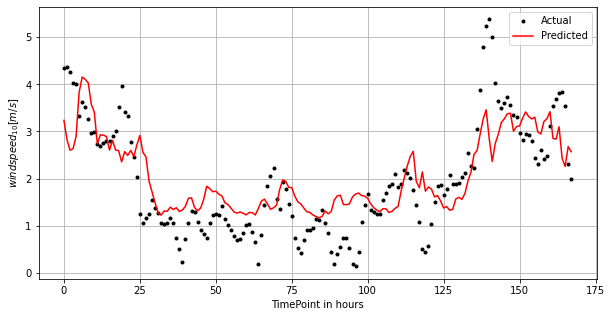

In [ ]:
evaluate(dense, X_test, y_test)

In [ ]:
explainer = shap.DeepExplainer(dense, X_train)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.


In [ ]:
shap_values = explainer.shap_values(X_test[:100])

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [ ]:
features = list(train.columns)
features

['t2m',
 'd2m',
 'msl',
 'tp',
 'ssrd',
 'windspeed_10',
 'windspeed_100',
 'Day sin',
 'Day cos',
 'Year sin',
 'Year cos']

In [ ]:
sv = np.array(shap_values)

In [ ]:
sv[0,:,0,:].shape

(100, 11)

In [ ]:
sv.shape

(1, 100, 24, 11)

In [ ]:
X_test.shape

(8730, 24, 11)

In [ ]:
X_test[:,0,:].shape

(8730, 11)

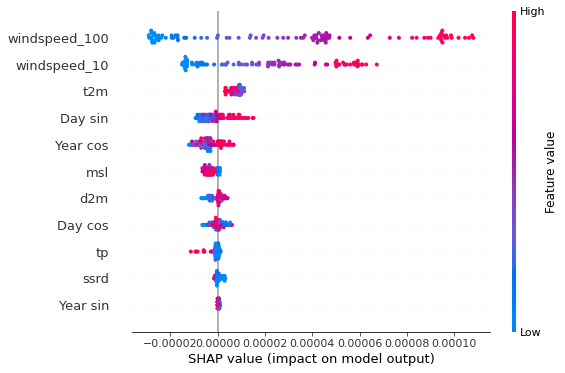

In [ ]:
shap.summary_plot(sv[0,:,0,:], X_test[:100,0,:], feature_names=features)

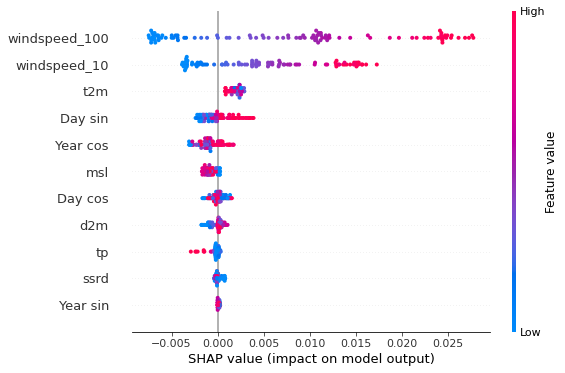

In [ ]:
shap.summary_plot(sv[0,:,5,:], X_test[:100,5,:], feature_names=features)

In [ ]:
shap_values[0][0]

array([[ 8.82731811e-06,  1.55361227e-06, -3.11111073e-06,
         4.16025442e-07,  1.48217986e-06,  2.82293485e-05,
         4.49881177e-05, -4.85045862e-06, -9.57438773e-07,
         5.63051778e-07, -3.98635934e-06],
       [-1.77989097e-03, -4.44853350e-04,  6.79159910e-04,
        -4.88824180e-05, -2.47897027e-04, -6.03917413e-03,
        -9.92827907e-03,  1.54650761e-04,  1.43399995e-04,
        -1.32061737e-04,  1.50160400e-03],
       [ 7.15144700e-04,  2.02949453e-04, -2.75327425e-04,
         1.76589860e-05,  8.69800470e-05,  2.38496259e-03,
         3.93738205e-03,  4.12344323e-04, -1.01653282e-05,
         6.51305468e-05, -8.45552648e-04],
       [ 2.73411831e-04,  9.52843216e-05, -1.10243997e-04,
         1.46911725e-05,  2.56841651e-05,  9.07648463e-04,
         1.69261565e-03,  3.48510140e-04,  2.24480781e-05,
         3.05216149e-05, -3.40001397e-04],
       [-1.25494103e-03, -5.69304927e-04,  5.85061778e-04,
        -1.08154353e-04, -7.90866973e-05, -4.70080822e-03,
  

In [ ]:
shap_values = explainer.shap_values(X_test[:500])

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [ ]:
sv = np.array(shap_values)

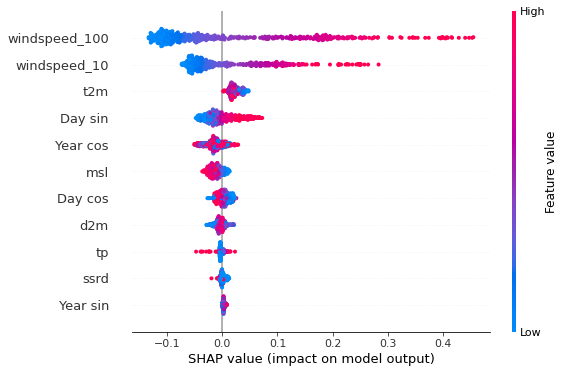

In [ ]:
shap.summary_plot(sv[0,:,-1,:], X_test[:500,-1,:], feature_names=features)

In [ ]:
sv_flattened = sv.reshape((1,500,24*11))

In [ ]:
sv[0,0,0]

array([ 8.82731811e-06,  1.55361227e-06, -3.11111073e-06,  4.16025442e-07,
        1.48217986e-06,  2.82293485e-05,  4.49881177e-05, -4.85045862e-06,
       -9.57438773e-07,  5.63051778e-07, -3.98635934e-06])

In [ ]:
sv[0,0,1]

array([-1.77989097e-03, -4.44853350e-04,  6.79159910e-04, -4.88824180e-05,
       -2.47897027e-04, -6.03917413e-03, -9.92827907e-03,  1.54650761e-04,
        1.43399995e-04, -1.32061737e-04,  1.50160400e-03])

In [ ]:
sv_flattened[0,0]

array([ 8.82731811e-06,  1.55361227e-06, -3.11111073e-06,  4.16025442e-07,
        1.48217986e-06,  2.82293485e-05,  4.49881177e-05, -4.85045862e-06,
       -9.57438773e-07,  5.63051778e-07, -3.98635934e-06, -1.77989097e-03,
       -4.44853350e-04,  6.79159910e-04, -4.88824180e-05, -2.47897027e-04,
       -6.03917413e-03, -9.92827907e-03,  1.54650761e-04,  1.43399995e-04,
       -1.32061737e-04,  1.50160400e-03,  7.15144700e-04,  2.02949453e-04,
       -2.75327425e-04,  1.76589860e-05,  8.69800470e-05,  2.38496259e-03,
        3.93738205e-03,  4.12344323e-04, -1.01653282e-05,  6.51305468e-05,
       -8.45552648e-04,  2.73411831e-04,  9.52843216e-05, -1.10243997e-04,
        1.46911725e-05,  2.56841651e-05,  9.07648463e-04,  1.69261565e-03,
        3.48510140e-04,  2.24480781e-05,  3.05216149e-05, -3.40001397e-04,
       -1.25494103e-03, -5.69304927e-04,  5.85061778e-04, -1.08154353e-04,
       -7.90866973e-05, -4.70080822e-03, -8.98360168e-03, -2.48164326e-03,
       -2.34552312e-04, -

In [ ]:
features_flattened = []
for i in range(24):
  for feature in features:
    features_flattened.append(feature+' t=-'+str(24-i)+'h')

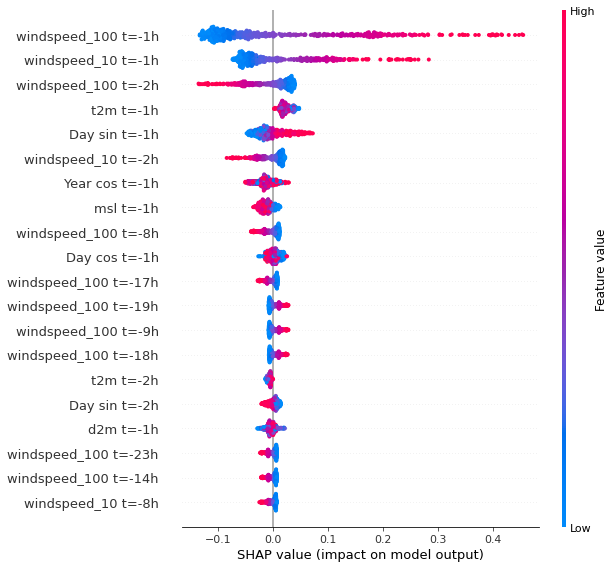

In [ ]:
shap.summary_plot(sv_flattened[0,:,:], X_test.reshape((X_test.shape[0], 24*11))[:500,:], feature_names=features_flattened)

##LSTM

In [ ]:
lstm = tf.keras.models.load_model('wind_lstm.h5')

Test Score: 1.1328 RMSE


1.13278678442391

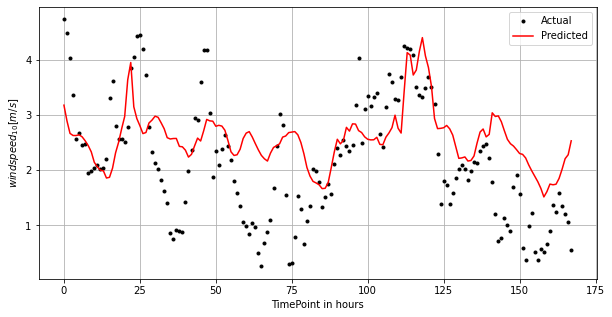

In [ ]:
evaluate(lstm, X_test, y_test)

In [ ]:
explainer = shap.GradientExplainer(lstm, X_train)
shap_values = explainer.shap_values(X_test[:500])
sv = np.array(shap_values)
features = list(train.columns)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [ ]:
sv.shape

(1, 500, 24, 11)

In [ ]:
X_test.shape

(8730, 24, 11)

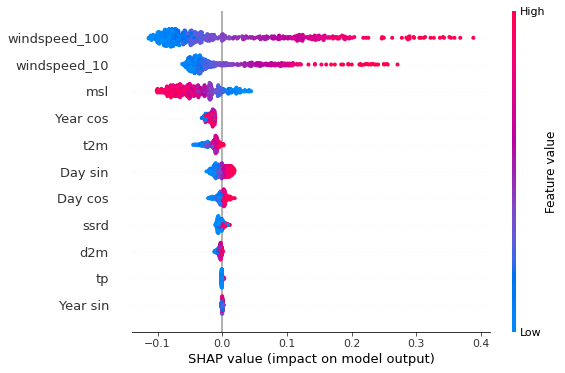

In [ ]:
shap.summary_plot(sv[0,:,-1,:], X_test[:500,-1,:], feature_names=features)

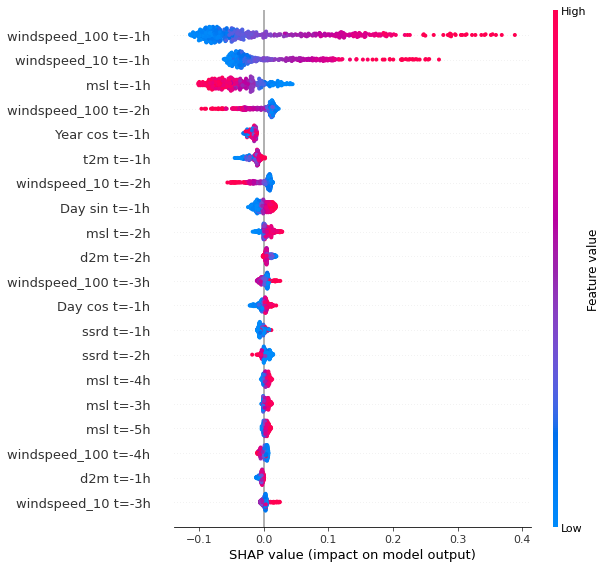

In [ ]:
sv_flattened = sv.reshape((1,500,24*11))
shap.summary_plot(sv_flattened[0,:,:], X_test.reshape((X_test.shape[0], 24*11))[:500,:], feature_names=features_flattened)